In [4]:
## SAUVEGARDE DES FICHIERS
# Sous Markdow : cela génère un sous repertoire avec les images
#!jupyter nbconvert --to markdown --no-input  Surveillance_deconfinement_2020_08_31.ipynb
# Sous HTML
#!jupyter nbconvert --to html --no-input  Surveillance_deconfinement_2020_08_31.ipynb

# Surveillance du COVID-19 en France

Bonjour,

L'objectif est de calculer les indicateurs et les modèles qui permettent de surveiller l'évolution de l'épidémie de Covid-19 en France :
- les chapites I,II et III présentent les données utilisées et les principes des calculs.
- les chapitres IV et V (bilan) décrivent l'évolution de l'épidémie et identifient les départements à surveiller.

Une mise à jour hebdomadaire est réalisée à partir des nouvelles données hospitalières et de tests de dépistage.

## I. Origine des données
- nombre quotidien d'hospitalisation, retour à domicile et décès par département (site data.gouv.fr)
- résultat quotidien des tests de dépistage virologiques par département (site data.gouv.fr)
- nombre d'habitant par département

In [3]:
from matplotlib import pyplot
import matplotlib
import math
import sklearn.metrics as sm
from sklearn.cluster import KMeans
from sklearn import datasets
import numpy as np
from scipy import stats
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import datetime
# Importation des librairies pour l'analyse des composantes principales
from sklearn import datasets
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
## Importation des données sous forme de dataframe ##
DonneesHosp = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7',sep = ';')
DonneesDep = pd.read_csv('Donnees\Population_departement.csv',sep = ';')
DonneesHosp = DonneesHosp.dropna(how = 'any') # suppression des lignes avec NaN
DonneesTestsViro = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/406c6a23-e283-4300-9484-54e78c8ae675',sep = ';')
DonneesTestsViro = DonneesTestsViro.dropna(how = 'any') # suppression des lignes avec NaN

## II. Construction des indicateurs

In [4]:
# filtrage des lignes uniquement avec la somme homme et femme
# Lien avec les données département
Donneesmixte = DonneesHosp[DonneesHosp['sexe']==0]
DonneesTestsViro = DonneesTestsViro.loc[DonneesTestsViro['cl_age90'] == 0] # conserve somme des classes d'age
DonneesTestsViro['p'] = DonneesTestsViro['P']
DonneesTestsViro['t'] = DonneesTestsViro['T']
del DonneesTestsViro['T']
del  DonneesTestsViro['P']
# suppression colonne sexe et reanimation 
del Donneesmixte['sexe']
del Donneesmixte['rea']
Donneesmixte = Donneesmixte.drop_duplicates(subset = ['dep', 'jour'])# supprime les doublons dep+jour
Donneesmixte = Donneesmixte.reset_index(drop = True) # réindexe
for i in range(len(Donneesmixte)):
    if Donneesmixte.at[i,'jour'].find('/') > 0:
        Donneesmixte.at[i,'jour'] = (str.split(Donneesmixte.at[i,'jour'],'/')[2]+'-'
                                     +str.split(Donneesmixte.at[i,'jour'],'/')[1]+'-'
                                     +str.split(Donneesmixte.at[i,'jour'],'/')[0])
# tri les valeurs par departement et jour
Dj = Donneesmixte.sort_values(by = ['dep', 'jour']) 
# Remise en forme du numero de département sur 2 chiffres minimum (0x)
for i in range(len(DonneesDep)-1): # Parcours des lignes dans l'ordre département + jour
    if len(DonneesDep.loc[DonneesDep.index[i], 'CODDEP']) == 1:
        DonneesDep.loc[DonneesDep.index[i], 'CODDEP'] = '0' + DonneesDep.loc[DonneesDep.index[i], 'CODDEP']
# Jointure sur le département pour récupérer le nombre d'habitant (PTOT) et les tests virologiques
Dj = pd.merge(Dj, DonneesDep, left_on = ['dep'], right_on = ['CODDEP'])
Dj = pd.merge(Dj, DonneesTestsViro, left_on = ['dep','jour'], right_on = ['dep','jour'], how = 'left' )
# Suppression de colonne
del Dj['CODDEP']
del Dj['NBARR']
del Dj['NBCAN']
del Dj['PMUN']
del Dj['cl_age90']

In [5]:
# Calcul pour la France entière = somme des départements
for j in Dj[Dj['dep']== '01'].itertuples(): # itération sur tous les jours
    ligne = len(Dj) # ajoute une ligne à la fin
    Dj.loc[ligne,['dep']] = '999'
    Dj.loc[ligne,['jour']] = j.jour
    Dj.loc[ligne,['DEP']] = 'France'
    Dj.loc[ligne,['hosp']] =  Dj[Dj['jour'] == j.jour]['hosp'].sum()  
    Dj.loc[ligne,['rad']] =  Dj[Dj['jour'] == j.jour]['rad'].sum()
    Dj.loc[ligne,['dc']] =  Dj[Dj['jour'] == j.jour]['dc'].sum()
    Dj.loc[ligne,['NBCOM']] =  Dj[Dj['jour'] == j.jour]['NBCOM'].sum()
    Dj.loc[ligne,['PTOT']] =  Dj[Dj['jour'] == j.jour]['PTOT'].sum()
    if Dj[Dj['jour'] == j.jour]['p'].isna().sum() < 10:
        Dj.loc[ligne,['p']] =  Dj[Dj['jour'] == j.jour]['p'].sum()
        Dj.loc[ligne,['t']] =  Dj[Dj['jour'] == j.jour]['t'].sum()
    else:
        Dj.at[ligne,'p'] = float('nan')
        Dj.at[ligne,'p'] = float('nan')
Dj = Dj.reset_index(drop = True) # réindexe

### Calcul des indicateurs par département
- taux d'hospitalisation (Thosp) : nombre d'hospitalisation pour 100 000 habitants
- taux d'entrée à l'hôpital (Treprod) : nombre d'entrée quotidienne pour 100 hospitalisations
- taux d'entrée à l'hôpital lissé (Treprodmoy) : moyenne sur 3 jours

In [6]:
# Initialisation de colonne de colonnnes
Dj['Entree'] = 0 # Colonne des entrées en hospitalisation
Dj['Sortie'] = 0 # Colonne des sorties en hospitalisation
Dj['Thosp'] = 0 # proportion : nb d'hospitalisation par 100 000 habitatns
Dj['Treprod'] = 0 # taux de reproduction quotidien : nb entrée  pour 100 hospitalisation
Dj['Treprodmoy'] = 0 # taux de reproduction lissé +/- 3 jours : nb entrée  pour 100 hospitalisation
Dj['tendance'] = 0 # tendance de la vitesse : pente des entrées / moyenne(entrée) sur 15 jours
Dj['incoherence'] = False # 
## Calcul des entrées, tests lissées et R0 à +/- 3 jours et ramenés à 100 000 habitants
Dj['Rj'] = float('nan') # taux de reproduction actualisé
Dj['Emoy'] = float('nan') # lissage proportion entrée +/- 3 jours
Dj['VEmoy'] = 0 # 2 si calculé avec toutes les données / 1 si calculé partiellement / 0 sinon
Dj['pmoy'] = float('nan') # lissage proportion de test +/- 3 jours
Dj['Vpmoy'] = 0 # 2 si calculé avec toutes les données / 1 si calculé partiellement / 0 sinon


# Calcul entree, sortie, rapport entree/hospitalisation et tendance
dep = 'Ain'
for i in range(len(Dj)): # Parcours des lignes dans l'ordre département + jour 
    # print('\r','departement : ',i, end='')
    Dj.at[i, 'Thosp'] = round(Dj.at[i, 'hosp'] / Dj.at[i, 'PTOT'] * 100000 )
    if Dj.at[i, 'dep'] == Dj.at[i, 'dep']: 
        if Dj.at[i, 'DEP'] != dep:
            dep = Dj.at[i, 'DEP']
            print('\r','calcul entree : ' + dep + '                              ', end='')
        # Calcul des entrées, sorties et taux de reproduction
        if i > 0 and Dj.at[i, 'dep'] == Dj.at[i-1, 'dep']: # le point précédent est dans le même département 
            if (Dj.at[i, 'rad'] > Dj.at[i-1, 'rad']) &  (Dj.at[i, 'dc'] > Dj.at[i-1, 'dc']):
                Sortie = Dj.at[i, 'rad'] - Dj.at[i-1, 'rad']  + Dj.at[i, 'dc'] - Dj.at[i-1, 'dc']
            elif (Dj.at[i, 'rad'] > Dj.at[i-1, 'rad']):
                Sortie = Dj.at[i, 'rad'] - Dj.at[i-1, 'rad']
            elif (Dj.at[i, 'dc'] > Dj.at[i-1, 'dc']):
                 Sortie =  Dj.at[i, 'dc'] - Dj.at[i-1, 'dc']
            else: Sortie = 0
            if Sortie > Dj.at[i-1, 'hosp']: # les sorties ne doivent pas dépasser les hospitalisations
                Sortie = 0
                Dj.at[i, 'incoherence'] = True
            Entree = Sortie + Dj.at[i, 'hosp'] - Dj.at[i-1, 'hosp']
            
            #datedebut = datetime.date(int(str.split(Dj.at[i-1,'jour'],'-')[0]),
            #                      int(str.split(Dj.at[i-1,'jour'],'-')[1]),int(str.split(Dj.at[i-1,'jour'],'-')[2]))
        
            #datefin = datetime.date(int(str.split(Dj.at[i,'jour'],'-')[0]),
            #                      int(str.split(Dj.at[i,'jour'],'-')[1]),int(str.split(Dj.at[i,'jour'],'-')[2]))
            #Njour = (datefin - datedebut).days
            Njour = 1
            if Entree > 0 and Entree < 0.6 * Njour * Dj.at[i, 'hosp'] and  Dj.at[i, 'hosp'] > 1:
                # en dessous de 15 hosp, le taux de reproduction a peu de sens et les entrées > 60 % du nb hosp
                Dj.at[i, 'Treprod'] = round(Entree / Njour / Dj.at[i, 'hosp'] * 100)
                Dj.at[i, 'Entree'] = Entree

            Dj.at[i, 'Sortie'] = Sortie
        
            
for i in range(len(Dj)): # Parcours des lignes dans l'ordre département + jour 
    # print('\r','departement : ',i, end='')
    if Dj.at[i, 'dep'] == Dj.at[i, 'dep']: 
        if Dj.at[i, 'DEP'] != dep:
            dep = Dj.at[i, 'DEP']
            print('\r','lissage entree : ' + dep + '                              ', end='')
        Emoy3 = 0    
        if i>=3 and i < len(Dj)-3 and  Dj.at[i-3,'DEP'] == dep and  Dj.at[i+3,'DEP'] == dep:
            Emoy3 =  Dj.loc[i-3:i+3,'Entree'].mean() 
            Dj.at[i,'Emoy'] = round(Emoy3  /  Dj.at[i,'PTOT'] * 100000,2)
            Dj.at[i,'VEmoy'] = 2
        elif i>=3 and i < len(Dj)-2 and  Dj.at[i-3,'DEP'] == dep and  Dj.at[i+2,'DEP'] == dep:
            Emoy3 =  Dj.loc[i-3:i+2,'Entree'].mean() 
            Dj.at[i,'Emoy'] = round(Emoy3  /  Dj.at[i,'PTOT'] * 100000,2)
            Dj.at[i,'VEmoy'] = 1
        elif i>=3 and i < len(Dj)-1 and  Dj.at[i-3,'DEP'] == dep and  Dj.at[i+1,'DEP'] == dep:
            Emoy3 =  Dj.loc[i-3:i+1,'Entree'].mean() 
            Dj.at[i,'Emoy'] = round(Emoy3  /  Dj.at[i,'PTOT'] * 100000,2)
            Dj.at[i,'VEmoy'] = 1
        elif i>=3 and i < len(Dj) and  Dj.at[i-3,'DEP'] == dep and  Dj.at[i,'DEP'] == dep:
            Emoy3 =  Dj.loc[i-3:i,'Entree'].mean() 
            Dj.at[i,'Emoy'] = round(Emoy3  /  Dj.at[i,'PTOT'] * 100000,2)
            Dj.at[i,'VEmoy'] = 1

        if i>=3 and i < len(Dj)-3 and  Dj.at[i-3,'DEP'] == dep and math.isnan(Dj.at[i-3,'p']) == False and  Dj.at[i+3,'DEP'] == dep and math.isnan(Dj.at[i+3,'p']) == False:
            Dj.at[i,'pmoy'] = round(Dj.loc[i-3:i+3,'p'].mean()   /  Dj.at[i,'PTOT'] * 100000,2)
            Dj.at[i,'Vpmoy'] = 2
        elif i>=3 and i < len(Dj)-2 and  Dj.at[i-3,'DEP'] == dep and math.isnan(Dj.at[i-3,'p']) == False and  Dj.at[i+2,'DEP'] == dep and math.isnan(Dj.at[i+2,'p']) == False:
            Dj.at[i,'pmoy'] = round(Dj.loc[i-3:i+2,'p'].mean()   /  Dj.at[i,'PTOT'] * 100000,2)
            Dj.at[i,'Vpmoy'] = 1
        elif i>=3 and i < len(Dj)-1 and  Dj.at[i-3,'DEP'] == dep and math.isnan(Dj.at[i-3,'p']) == False and  Dj.at[i+1,'DEP'] == dep and math.isnan(Dj.at[i+1,'p']) == False:
            Dj.at[i,'pmoy'] = round(Dj.loc[i-3:i+1,'p'].mean()   /  Dj.at[i,'PTOT'] * 100000,2) 
            Dj.at[i,'Vpmoy'] = 1
        elif i>=3 and i < len(Dj) and  Dj.at[i-3,'DEP'] == dep and math.isnan(Dj.at[i-3,'p']) == False and  Dj.at[i,'DEP'] == dep and math.isnan(Dj.at[i,'p']) == False:
            Dj.at[i,'pmoy'] = round(Dj.loc[i-3:i,'p'].mean()   /  Dj.at[i,'PTOT'] * 100000,2)
            Dj.at[i,'Vpmoy'] = 1
        # pas de valeur au début
        elif i>=3 and i < len(Dj)-3 and  Dj.at[i-2,'DEP'] == dep and math.isnan(Dj.at[i-2,'p']) == False and  Dj.at[i+3,'DEP'] == dep and math.isnan(Dj.at[i+3,'p']) == False:
            Dj.at[i,'pmoy'] = round(Dj.loc[i-2:i+3,'p'].mean()   /  Dj.at[i,'PTOT'] * 100000,2)
            Dj.at[i,'Vpmoy'] = 2
        elif i>=3 and i < len(Dj)-3 and  Dj.at[i-1,'DEP'] == dep and math.isnan(Dj.at[i-1,'p']) == False and  Dj.at[i+3,'DEP'] == dep and math.isnan(Dj.at[i+3,'p']) == False:
            Dj.at[i,'pmoy'] = round(Dj.loc[i-1:i+3,'p'].mean()   /  Dj.at[i,'PTOT'] * 100000,2)
            Dj.at[i,'Vpmoy'] = 2
        elif i>=3 and i < len(Dj)-3 and  Dj.at[i,'DEP'] == dep and math.isnan(Dj.at[i,'p']) == False and  Dj.at[i+3,'DEP'] == dep and math.isnan(Dj.at[i+3,'p']) == False:
            Dj.at[i,'pmoy'] = round(Dj.loc[i:i+3,'p'].mean()   /  Dj.at[i,'PTOT'] * 100000,2)
            Dj.at[i,'Vpmoy'] = 2
    
        if i>=14  and  Dj.at[i-14,'DEP'] == dep :
            Emoy14 = Dj.loc[i-14:i,'Emoy'].mean()
            if Emoy14 > 0:
                Dj.at[i,'Rj'] = round(Dj.at[i,'Emoy'] / Emoy14 ,2)  
            
        if Emoy3 > 0 and Dj.at[i, 'hosp'] > 15:  
            Dj.at[i, 'Treprodmoy'] = round(Emoy3 / Dj.at[i, 'hosp'] * 100) 
            
print('\r','                                                            '    )         

                                                                       lissage entree : Guadeloupe                              


### Classification quotidienne des départements

In [7]:
Dj['CThosp'] = -1 # classement du taux d'hospitalisation (en cluster)
Dj['CTreprod'] = 0 # Classement du taux de reproduction (en cluster)

## Classement quotidien des départements en taux d'hospitalisation
x = Dj[Dj['jour'] < '2020-06-15']['Thosp'] # fin phase 3 où tous les départements métropolitain sont verts
model=KMeans(n_clusters=5)
model.fit(x.values.reshape(-1, 1)) # conversion en vecteur colonne
intensite = np.zeros((4, 1), dtype = int) # limite supérieure des 4 premières zones
intensite[0] = (np.sort(model.cluster_centers_,0)[0]  + np.sort(model.cluster_centers_,0)[1]) / 2
intensite[1] = (np.sort(model.cluster_centers_,0)[1]  + np.sort(model.cluster_centers_,0)[2]) / 2
intensite[2] = (np.sort(model.cluster_centers_,0)[2]  + np.sort(model.cluster_centers_,0)[3]) / 2
intensite[3] = (np.sort(model.cluster_centers_,0)[3]  + np.sort(model.cluster_centers_,0)[4]) / 2

# Valeurs figées avec les données du 18 juillet (dont Mayotte)
intensite[0] = 14
intensite[1] = 34
intensite[2] = 62
intensite[3] = 104


# integration des résultats dans le tableau dep+jour
for i in range(len(Dj)):
    if Dj.at[i,'Thosp'] < intensite[0]:Dj.at[i,'CThosp'] = 0
    elif Dj.at[i,'Thosp'] < intensite[1]:Dj.at[i,'CThosp'] = 1
    elif Dj.at[i,'Thosp'] < intensite[2]:Dj.at[i,'CThosp'] = 2
    elif Dj.at[i,'Thosp'] < intensite[3]:Dj.at[i,'CThosp'] = 3
    else:Dj.at[i,'CThosp'] = 4

print("Catégories pour le taux d'hospitalisation (/ 100 000 hab.) :")
print('très bas < ', intensite.reshape(-1)[0],' < bas < ', intensite.reshape(-1)[1], 
      ' < moyen < ', intensite.reshape(-1)[2], ' < élevé < ', intensite.reshape(-1)[3],' < très élevé')


## Classement quotidien des départements par taux de reproduction ##
x = Dj.loc[Dj['jour'] < '2020-05-11']['Treprodmoy'] # Début du déconfinement
model=KMeans(n_clusters=3)
model.fit(x.values.reshape(-1, 1))
# Classement des clusters dans l'ordre ascendant des proportions
intensite = np.zeros((2, 1), dtype = int) # limite supérieure des 4 premières zones
intensite[0] = (np.sort(model.cluster_centers_,0)[0]  + np.sort(model.cluster_centers_,0)[1]) / 2
intensite[1] = (np.sort(model.cluster_centers_,0)[1]  + np.sort(model.cluster_centers_,0)[2]) / 2
centreTreprod = np.zeros((3, 1), dtype = int)
centreTreprod[0] = np.sort(model.cluster_centers_,0)[0]
centreTreprod[1] = np.sort(model.cluster_centers_,0)[1]
centreTreprod[2] = np.sort(model.cluster_centers_,0)[2]

# Valeurs figées avec les données du 18 juillet (dont Mayotte)
intensite[0] = 6
intensite[1] = 16
centreTreprod[0] = 2
centreTreprod[1] = 10
centreTreprod[2] = 22
# integration des résultats dans le tableau dep+jour
for i in range(len(Dj)):
    if Dj.at[i,'Treprodmoy'] < intensite[0]:Dj.at[i,'CTreprod'] = 0
    elif Dj.at[i,'Treprodmoy'] < intensite[1]:Dj.at[i,'CTreprod'] = 1
    else:Dj.at[i,'CTreprod'] = 2
print()
print("Catégories pour le taux d'entrée à l'hôpital (/ 100 hosp.)")
print('bas < ', intensite.reshape(-1)[0], ' < élevé < ', intensite.reshape(-1)[1], ' < très élevé ')


Catégories pour le taux d'hospitalisation (/ 100 000 hab.) :
très bas <  14  < bas <  34  < moyen <  62  < élevé <  104  < très élevé

Catégories pour le taux d'entrée à l'hôpital (/ 100 hosp.)
bas <  6  < élevé <  16  < très élevé 


### Calcul d'une alerte sur le taux d'entrée à l'hôpital
Les conditions :
- le taux d'hospitalisation n'est pas bas (> 14 hosp. / 100 000 hab.)
- le taux d'entrée à l'hôpital est élevé (> 6 entrées / 100 hosp.)

ou
- le taux d'hospitalisation est bas (< 14 hosp. / 100 000 hab.)
- le taux d'entrée à l'hôpital est très élevé (> 16 entrées / 100 hosp)

Cette alerte détecte une accélération de l'épidémie (cf. IV.B.1).

In [8]:
Dj['alerte'] = False # indique un taux d'entré élevé
## Creation d'une alerte si sur les 4 derniers jours le taux de reproduction lissé n'est pas faible

dep = 'Ain'
for i in range(len(Dj)): # Parcours des lignes dans l'ordre département + jour 
    if Dj.at[i, 'dep'] == Dj.at[i, 'dep']: 
        if Dj.at[i, 'DEP'] != dep:
            dep = Dj.at[i, 'DEP']
            print('\r','calcul alarme : ' + dep + '                              ', end='')
        if Dj.at[i,'CThosp'] == 0  and Dj.at[i,'CTreprod'] < 2 :Dj.at[i,'alerte'] = False
        elif Dj.at[i,'CThosp'] == 0  and Dj.at[i,'CTreprod'] == 2:Dj.at[i,'alerte'] = True
        elif (Dj.at[i,'CThosp'] > 0 ) and Dj.at[i,'CTreprod'] == 0:Dj.at[i,'alerte'] = False
        elif (Dj.at[i,'CThosp'] > 0 ) and Dj.at[i,'CTreprod'] > 0 :Dj.at[i,'alerte'] = True
print('\r','                                                                                    ', end='')

In [9]:
## Construction des courbes

In [10]:
###  Evolution des taux d'hospitalisation

In [11]:
# Visualisation du taux d'hospitalisation pour l'ensemble des départements ##
def courbe_TxHosp(dep):
    fig1 = pyplot.figure(1,figsize = (15, 5))
    for i in range(len(Dj)):
        if (Dj.at[i,'jour'] == Dj['jour'].max()) and (
            (dep == 'France') or (Dj.at[i,'DEP'] == dep ) or (Dj.at[i,'DEP'] == 'France' )) : # recherche de la dernière ligne du département
        # Choix des couleurs, épaisseur en fonction du taux hosp, taux reprod et tendance
            epaisseur = 1
            legende =''
            transparence = 0.5
            if Dj.at[i,'CThosp'] >= 3 :
                if  Dj.loc[i-3:i,'alerte'].max() == True:col = 'red';epaisseur = 3;transparence =1
                elif Dj.loc[i-3:i,'PredicTest'].max() >= 20:col = 'yellow';epaisseur = 2;transparence = 1
                else:col = 'darkgoldenrod';epaisseur = 3;transparence =1
            elif Dj.at[i,'CThosp'] >= 1 :
                if  Dj.loc[i-3:i,'alerte'].max() == True :col = 'deeppink';epaisseur = 3;transparence =1
                elif Dj.loc[i-3:i,'PredicTest'].max() >= 20:col = 'yellow';epaisseur = 2;transparence = 1
                else:col = 'darkorange';epaisseur = 1;transparence =1    
            elif Dj.loc[i-3:i,'alerte'].max() == True :col = 'deeppink';epaisseur = 3;transparence =1
            elif Dj.loc[i-3:i,'PredicTest'].max() >= 20:col = 'yellow';epaisseur = 3;transparence = 1
            else:col ='grey';transparence =0.7
            if Dj.at[i,'dep'] == '999':epaisseur = 5 ;col = 'black';transparence =1
            elif Dj.at[i,'DEP'] == dep:epaisseur = 5 ;col = 'blue';legende =Dj.at[i,'DEP'];transparence =1
        # Courbe du département       
            Djdep = Dj.loc[Dj['dep'] == Dj.at[i,'dep'],['jour','Thosp']] # récupération du département
            pyplot.plot(Djdep['jour'],Djdep['Thosp'],col,linewidth = epaisseur,label = legende, alpha = transparence)
    # Paramètres généraux
    if dep == 'France':
        pyplot.plot(0,0,'red', linewidth = 5,          label = "critique")
        pyplot.plot(0,0,'darkgoldenrod',linewidth = 5, label = "élevé")
        pyplot.plot(0,0,'darkorange',linewidth = 3,    label = "moyen")
        pyplot.plot(0,0,'deeppink',linewidth = 5, label = "Alerte sur les entrées à l'hôpital")
        pyplot.plot(0,0,'yellow',linewidth = 5, label = "Alerte sur les tests positifs")
        #pyplot.plot(0,0,'grey',linewidth = 1,label = "taux d'hosp. faible")
    pyplot.plot(0,0,'black',linewidth = 5, label = 'France')
    pyplot.legend(loc='upper right')
    pyplot.title("Evolution du taux d'hospitalisation par département")
    pyplot.xlabel('Date' , fontsize = 12) # titre des absisses
    pyplot.ylabel('hosp. / 100 000 hab. ' , fontsize = 12) # titre des ordonnées
    axes = pyplot.gca()
    axes.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(30)) # impose 8 graduations maxi
    for label in pyplot.gca().xaxis.get_ticklabels(): # mise en forme du label des x (rotation verticale)
        label.set_rotation(90)
    pyplot.grid() # grille
    pyplot.show()
    #if dep == 'France':fig1.savefig('Images\Evolution des hospitalisations_' + dep + '.png')
#courbe_TxHosp('France')

In [12]:
### Evolution des taux de reproduction

In [13]:
## Visualisation du taux d'hospitalisation de l'ensemble des départements pour vérifer la cohérence ##
def courbe_TxEntree(dep):
#dep = '63'
    fig2 = pyplot.figure(2,figsize = (15, 5))
    for i in range(len(Dj)):
        if (Dj.at[i,'jour'] == Dj['jour'].max()) and (
            (dep == 'France') or (Dj.at[i,'DEP'] == dep ) or (Dj.at[i,'DEP'] == 'France' )): 
            # recherche de la dernière ligne du département
            couleur = 'grey'; epaisseur = 1; legende ='';transparence = 0.7
            if  Dj.at[i,'dep'] == '999' : couleur = 'black' ; epaisseur = 5 ; legende='France';transparence = 1
            elif  Dj.at[i,'DEP'] == dep : couleur = 'blue' ; epaisseur = 5 ; legende=Dj.at[i,'DEP'];transparence = 1
            elif Dj.loc[i-3:i,'alerte'].max() == True : couleur = 'deeppink';epaisseur = 2;transparence = 1
            elif Dj.loc[i-3:i,'PredicTest'].max() >= 20:couleur = 'gold';epaisseur = 2;transparence = 1
            # Courbe du département
            if Dj.at[i, 'incoherence'] == False:
                Djdep = Dj.loc[Dj['dep'] == Dj.at[i,'dep'],['jour','Treprodmoy']] # récupération du département
                pyplot.plot(Djdep['jour'],Djdep['Treprodmoy'],
                            couleur,linewidth=epaisseur,label =legende, alpha = transparence)
    # Paramètres généraux
    pyplot.axhline(y = centreTreprod [2],color ='red',linewidth = 3)
    if centreTreprod [1] != 0 :
        pyplot.axhline(y = centreTreprod [1],color ='deeppink',linewidth = 3)
    pyplot.axhline(y = centreTreprod [0],color ='grey',linewidth = 3)
    pyplot.title("Evolution du taux d'entrée à l'hôpital par département")
    pyplot.xlabel('Date' , fontsize = 12) # titre des absisses
    pyplot.ylabel("Entrée / 100 hosp." , fontsize = 12) # titre des ordonnées
    axes = pyplot.gca()
    axes.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(30)) # impose 8 graduations maxi
    for label in pyplot.gca().xaxis.get_ticklabels(): # mise en forme du label des x (rotation verticale)
        label.set_rotation(90)
    pyplot.grid() # grille
    if dep == 'France':
        pyplot.plot(0,0,'deeppink',linewidth = 5, label = "Alerte sur les entrées à l'hôpital")
        pyplot.plot(0,0,'gold',linewidth = 5, label = "Alerte sur les tests positifs")
    pyplot.legend(loc='upper right')
    pyplot.show() 
    #if dep == 'France':fig2.savefig('Images\Evolution des entrées_' + dep + '.png')
#courbe_TxEntree('France')

In [14]:
### Evolution pour les taux d'hospitalisation les plus élevés

In [15]:
# Visualisation du taux d'hospitalisation pour l'ensemble des départements ##
def courbe_TxHospHaut(dep):
    icol = 0
    cm = matplotlib.cm.get_cmap('tab20')
    fig3 = pyplot.figure(1,figsize = (15, 5))
    for i in range(len(Dj)):
        # recherche de la catégorie maxi des départements pour les afficher
        if (Dj.at[i,'jour'] == Dj['jour'].max()) and ( 
            (Dj.at[i,'DEP'] == 'France') |
            (Dj.at[i,'DEP'] == dep) |
            (Dj.at[i,'CThosp'] == 4) | 
            ((Dj.loc[ (Dj['jour'] == Dj['jour'].max()),'CThosp'].max() == 3) and (Dj.at[i,'CThosp'] == 3)) |
            ((Dj.loc[ (Dj['jour'] == Dj['jour'].max()),'CThosp'].max() == 2) and (Dj.at[i,'CThosp'] == 2)) |
            ((Dj.loc[ (Dj['jour'] == Dj['jour'].max()),'CThosp'].max() == 1) and (Dj.at[i,'CThosp'] == 1)) ):
        # Choix des couleurs, épaisseur en fonction du taux hosp, taux reprod et tendance
            legende =  Dj.at[i,'DEP']
            if icol >= 20:icol = 0
            col = cm.colors[icol]
            icol = icol + 1 
            epaisseur = 5
            if Dj.at[i,'DEP'] == 'France':epaisseur = 5 ;col = 'black'
            elif Dj.at[i,'DEP'] == dep:epaisseur = 5 ;col = 'grey'
        # Courbe du département       
            Djdep = Dj.loc[Dj['dep'] == Dj.at[i,'dep'],['jour','Thosp']] # récupération du département
            pyplot.plot(Djdep['jour'],Djdep['Thosp'],c=col,linewidth = epaisseur,label = legende)
    # Paramètres généraux
    pyplot.legend(loc='upper right')
    pyplot.title("Evolution des départements avec les taux d'hospitalisation les plus élevés")
    pyplot.xlabel('Date' , fontsize = 12) # titre des absisses
    pyplot.ylabel('hosp. / 100 000 hab. ' , fontsize = 12) # titre des ordonnées
    axes = pyplot.gca()
    axes.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(30)) # impose 8 graduations maxi
    for label in pyplot.gca().xaxis.get_ticklabels(): # mise en forme du label des x (rotation verticale)
        label.set_rotation(90)
    pyplot.grid() # grille
    pyplot.show()
    
#courbe_TxHospHaut('Mayenne') # pour test

In [16]:
## Construction des courbes R0 et suivi des tests virologiques

In [17]:
## Evolution du R0 et des entrées lisées dans un département sélectionné
def R0_departement(dep):
    ## Courbe
    fig5 = pyplot.figure(5,figsize = (15, 5))
    # Taux de reproduction
    axe1=pyplot.gca()
    axe1.plot(Dj[(Dj['DEP'] == dep) ]['jour'],
              Dj[(Dj['DEP'] == dep) ]['Emoy'],c='blue',linewidth = 5,linestyle = ' ')
    axe1.plot(Dj[(Dj['DEP'] == dep) & (Dj['VEmoy'] == 2)]['jour'],
              Dj[(Dj['DEP'] == dep) & (Dj['VEmoy'] == 2)]['Emoy'],c='blue',linewidth = 5,label='Entree',linestyle = '-')
    axe1.plot(Dj[(Dj['DEP'] == dep) & (Dj['VEmoy'] == 1)]['jour'],
              Dj[(Dj['DEP'] == dep) & (Dj['VEmoy'] == 1)]['Emoy'],c='blue',linewidth = 3,label='En cours',linestyle = '--')
    axe1.legend( loc='upper left') # 
    pyplot.yscale('log')
    pyplot.ylabel('Entree / 100 000 hab')
    # Délimitation des phases
    axe1.vlines(x = '2020-03-18',color ='red',linewidth = 3,linestyle='--',ymin = 0,ymax= 5.0)
    axe1.vlines(x = '2020-05-11',color ='deeppink',linewidth = 3,linestyle='--',ymin = 0, ymax= 5.0)
    axe1.vlines(x = '2020-06-02',color ='deeppink',linewidth = 3,linestyle='--',ymin = 0, ymax= 5.0)
    axe1.vlines(x = '2020-06-15',color ='green',linewidth = 3,linestyle='--',ymin = 0, ymax= 5.0)
    axe1.vlines(x = '2020-07-20',color ='gold',linewidth = 3,linestyle='--',ymin = 0, ymax= 5.0)
    axe1.text('2020-03-18', 0.04, ' Confinement ', horizontalalignment = 'left',
                verticalalignment = 'center',color='red',fontsize = 12,fontweight = 'bold')
    axe1.text('2020-05-11', 0.04, ' Deconfinement ', horizontalalignment = 'right',
                verticalalignment = 'center',color='deeppink',fontsize = 12,fontweight = 'bold')
    axe1.text('2020-05-11', 0.04, ' < 100 km ', horizontalalignment = 'left',
                verticalalignment = 'center',color='deeppink',fontsize = 12,fontweight = 'bold')
    axe1.text('2020-06-02', 0.04, ' Restaurant ', horizontalalignment = 'left',
                verticalalignment = 'center',color='deeppink',fontsize = 12,fontweight = 'bold')
    axe1.text('2020-06-15', 0.02, ' Loisirs ', horizontalalignment = 'left',
                verticalalignment = 'center',color='green',fontsize = 12,fontweight = 'bold')
    axe1.text('2020-07-20', 0.04, ' Masque lieux clos ', horizontalalignment = 'left',
                verticalalignment = 'center',color='gold',fontsize = 12,fontweight = 'bold')

    # axes des entrées
    axe2 = pyplot.gca().twinx()
    Ylim = np.ones((len(Dj[(Dj['DEP'] == dep) ]), 1), dtype = float)
    axe2.plot(Dj[(Dj['DEP'] == dep) ]['jour'],
              Ylim,c='red',
                    linewidth = 3, label = 'critique',linestyle = '--')
    axe2.plot(Dj[(Dj['DEP'] == dep) & (Dj['VEmoy'] == 2)]['jour'],
              Dj[(Dj['DEP'] == dep) & (Dj['VEmoy'] == 2)]['Rj'],c='black',
                    linewidth = 3, label = 'R0',linestyle = '-')
    axe2.plot(Dj[(Dj['DEP'] == dep) & (Dj['VEmoy'] == 1)]['jour'],
              Dj[(Dj['DEP'] == dep) & (Dj['VEmoy'] == 1)]['Rj'],c='black',
                    linewidth = 3, label = 'en cours',linestyle = '--')
    axe2.legend( loc='upper right') # grille
    pyplot.ylabel('R0')
    pyplot.ylim(0, 2)
    #axe2.text(Dj.loc[(Dj['jour'] == Dj['jour'].max()) & (Dj['DEP'] == dep), 'jour'],
    #            Dj.loc[(Dj['jour'] == Dj['jour'].max()) & (Dj['DEP'] == dep), 'Rj'],
    #             " "+ str(Dj.loc[(Dj['jour'] == Dj['jour'].max()) & (Dj['DEP'] == dep), 'Rj'].values[0]),
    #            horizontalalignment = 'left',verticalalignment = 'center',color='black',fontsize = 12,fontweight = 'bold')

    axe1.set_yticks([0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10])
    axe1.yaxis.set_ticklabels(['0.01','0.02','0.05','0.1','0.2','0.5','1','2','5', '10'])
    # Paramètres courbe
    for label in axe1.xaxis.get_ticklabels():
        label.set_rotation(90)
    axe1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(30)) # impose 8 graduations maxi
    axe2.grid() # grille
    pyplot.title("Evolution du taux de reproduction et des entrées : " + dep)
    pyplot.xlabel('Date' , fontsize = 12) # titre des absisses

    pyplot.show()

#R0_departement('France')

### III. Relation entre les entrées à l'hôpital et les résultats des tests virologiques.

### Modélisation à partir d'une régression logistique PLS

Le modèle établit la relation entre les entrées à l'hôpital et les tests positifs pour :
- anticiper une hausse des entrées à l'hôpital,
- vérifier que les entrées à l'hôpital sont accompagnées de tests de dépistage.

La relation est établie pendant la phase 1 et 2 du déconfinement (jusqu'au 15 juin) où les tests de dépistage sont en place.

**Les données explicatives** sont les taux de test positif (/ 100 000 hab.) sur les 10 derniers jours précédent l'alerte.

**Les données à prédire** sont la présence d'une alerte sur le taux d'entrée à l'hôpital (> 6 entrées / 100 hosp.).

In [18]:
## régression logistique 
# Observation sur y(dep,j) = taux de reproduction élevée en hospital au jour  j pour le departement dep 
# variable explicative : test positif (j-i, dep) pour i = 0 à 9 (sur les 10 derniers jours)

## Structuration des données
dep = 'France'
npoint = 10 # nombre d'historique à prendre en compte
Yentree = np.zeros((len(Dj), 1), dtype = float)
Xtest = np.zeros((len(Dj), npoint), dtype = float)
Index = np.zeros((len(Dj),1), dtype = int)
j = 0
for i in range(len(Dj)): # Parcours des lignes dans l'ordre département + jour
    if  Dj.at[i,'jour'] < '2020-06-15':# période d'apprentissage : phase 1 et 2
        if math.isnan(Dj.at[i,'CTreprod']) == False and  math.isnan(Dj.at[i,'pmoy']) == False:
            if (i >= (npoint - 1) and Dj.at[i,'dep'] == Dj.at[i- (npoint - 1),'dep'] 
                and math.isnan(Dj.at[i-(npoint - 1),'pmoy']) == False and 
                (Dj.loc[i,'alerte'] == False or Dj.loc[i-1,'alerte'] == False 
                or Dj.loc[i-2,'alerte'] == False or Dj.loc[i-3,'alerte'] == False)) :
                    # on ne prend plus en compte  au delà de 3 alertes consécutives
                    if Dj.loc[i,'alerte'] == True : 
                        Yentree[j] = 1
                        #print(Dj.loc[i,['DEP','jour']].values)
                    Xtest[j,:] = Dj.loc[i-(npoint - 1):i ,'pmoy'].values
                    for k in range((npoint - 1)): # remplacement des valeurs NaN par la valeur précédente
                        if math.isnan(Xtest[j,k+1]) == True:
                            Xtest[j,k+1] = Xtest[j,k] # 

                    Index[j] = i # pour retrouver la ligne d'origine
                    j = j + 1
Xtest = Xtest[0:j,:] # redimensionne
Index = Index[0:j]
YCTreprod = Yentree[0:j]

## Calcul du la regression logistique PLS de l'alerte des entrées sur les tests virologiques
# Initialisation
Xm = Xtest.mean(0) # moyenne par variables
X = Xtest - Xm # matrice des tests centrées
Y = YCTreprod
k = len(X[1,:]) # nombre de variables explicatives
n = len(X[:,1]) # nombre d'observation

In [19]:
# 1ère composante

w1 = np.zeros(k, dtype = float)
t1 = np.zeros(n,dtype = float)
# RLog
for j in range(k):
    Xj = X[:,j] # variables Xj
    Xj_stat = sm.add_constant(Xj)
    model = sm.Logit(Y, Xj_stat)
    result = model.fit(disp=0)
    w1[j] = result.params[1]
w1=1/(np.linalg.norm(w1))*w1 # normalisation
t1 = np.dot(X,w1)
w1f = w1.reshape(1,-1)
# RLog sur t1
t1_stat = sm.add_constant(t1)
model = sm.Logit(Y, t1_stat)
result = model.fit(disp=0)
# Calcul du résidu X1 par RegLin
regressor = LinearRegression()
regressor.fit(t1.reshape(-1, 1), X)
p1 = regressor.coef_ 
X1 =  X - np.dot(t1.reshape(-1,1),p1.reshape(1,-1)) # résidu de X
result1 = result
## Affichage des résultats
"""
print()
print('1ère composante insuffisante')
print()
print ('Matrice de confusion pour une probabilité à plus de 20 %')
print('ligne : valeur 0/1 et colonne : prédiction 0/1')
print(result.pred_table(0.2))
"""
print()

In [20]:
# 2ème composante

w2 = np.zeros(k, dtype = float)
t2 = np.zeros(n,dtype = float)
for j in range(k):
    tX1j = np.concatenate([t1.reshape(-1,1), X1[:,j].reshape(-1,1)], axis = 1)
    tX1j_stat = sm.add_constant(tX1j)
    model = sm.Logit(Y, tX1j_stat)
    result = model.fit(disp=0)
    w2[j] = result.params[2]
w2=1/(np.linalg.norm(w2))*w2 # normalisation
t2 = np.dot(X1,w2)
# Calcul de w2* qui relie t2 à X et non X1
w2f=w2-w1*np.dot(w2.reshape(1,-1),p1.reshape(-1,1))
w2ftest = np.dot(np.identity(k)-np.dot(w1.reshape(-1,1),p1.reshape(1,-1)),w2) # plus propre

# RLog sur t1,t2
tx = np.concatenate([t1.reshape(-1,1),t2.reshape(-1,1)], axis = 1)
tx_stat = sm.add_constant(tx)
model = sm.Logit(Y, tx_stat)
result = model.fit(disp=0)
result2 = result
# Calcul du résidu X2 par RegLin
regressor = LinearRegression()
regressor.fit(t2.reshape(-1, 1), X1)
p2 = regressor.coef_ 
X2 =  X1 - np.dot(t2.reshape(-1,1),p2.reshape(1,-1)) # résidu de X

## Affichage des résultats
"""
print()
print('2ème composante insuffisante')
print()
print ('Matrice de confusion pour une probabilité à plus de 20 %')
print('ligne : valeur 0/1 et colonne : prédiction 0/1')
print(result.pred_table(0.2)) 
"""
print()

In [21]:
# 3ème composante

# calcul t2,w2 par RegLog
w3 = np.zeros(k, dtype = float)
t3 = np.zeros(n,dtype = float)
for j in range(k):
    tX2j = np.concatenate([t1.reshape(-1,1),t2.reshape(-1,1), X2[:,j].reshape(-1,1)], axis = 1)
    tX2j_stat = sm.add_constant(tX2j)
    model = sm.Logit(Y, tX2j_stat)
    result = model.fit(disp=0)
    w3[j] = result.params[3]
w3=1/(np.linalg.norm(w3))*w3 # normalisation
t3 = np.dot(X2,w3)
# Calcul de w3* qui relie t3 à X et non X2
w3f1=w3-w2*np.dot(w3.reshape(1,-1),p2.reshape(-1,1)) # t3 = X1*w3f1
w3f = w3f1-w1*np.dot(w3f1.reshape(1,-1),p1.reshape(-1,1)) # t3 = X*w3f

# RLog sur t1,t2,t3
tx = np.concatenate([t1.reshape(-1,1),t2.reshape(-1,1),t3.reshape(-1,1)], axis = 1)
tx_stat = sm.add_constant(tx)
model = sm.Logit(Y, tx_stat)
result = model.fit(disp=0)
result3 = result
tx3 = tx_stat # matrice des variables latentes t par observations + 1 constante
# Calcul du résidu X3 par RegLin
regressor = LinearRegression()
regressor.fit(t3.reshape(-1, 1), X2)
p3 = regressor.coef_ 
X3 =  X2 - np.dot(t3.reshape(-1,1),p3.reshape(1,-1)) # résidu de X

## Affichage des résultats

'''
print('3ème composante')


print(result3.summary()) # test significatif à 5 % (LLR p-value pour le modèle global / P>z pour un coefficient)

print()
print('w1f : ' ,np.round(w1f.reshape(1,-1),1),'p1 : ' ,np.round(p1.reshape(1,-1),1))
print('w2f : ' ,np.round(w2f.reshape(1,-1),1),'p2 : ' ,np.round(p2.reshape(1,-1),1))
print('w3f : ' ,np.round(w3f.reshape(1,-1),1),'p3 : ' ,np.round(p3.reshape(1,-1),1))
print()
print ('Matrice de confusion pour une probabilité à plus de 20 %')
print('ligne : valeur 0/1 et colonne : prédiction 0/1')
print(np.round(result.pred_table(0.2),0)) 

pyplot.figure(12,figsize = (15, 10))
pyplot.subplot(3,2,1) # prédiction
pyplot.plot(100 * result.predict(tx_stat),Y,linestyle='',marker='.')
pyplot.xlim(0,100)
pyplot.xlabel("%")
pyplot.ylabel('Alerte sur les entrées = 1')
pyplot.title("Probabilité d'avoir une alerte sur les entrées / tests positifs")
pyplot.subplot(3,2,2) # composantes
pyplot.title('courbe des composantes')
pyplot.plot(Xm,label='moy')
pyplot.plot(p1,label='p1')
pyplot.plot(p2,label='p2')
pyplot.plot(p3,label='p3')
pyplot.xlabel('jour')
pyplot.grid()
pyplot.legend()
pyplot.subplot(3,2,3) # cartes des charges 1 et 2
pyplot.xlim(1.2*min(result.params[1],0,w1f.min()),1.2*max(result.params[1],w1f.max()))
pyplot.ylim(1.2*min(result.params[3],w3f.min(),result.params[2],w2f.min()),
            1.2*max(result.params[3],w3f.max(),result.params[2],w2f.max()))
for j in range(len(w1f[0,:])):
    pyplot.annotate('X'+str(j),(w1f[0,j],w2f[0,j]),color='red')
pyplot.annotate('Y12',(result.params[1],result.params[2]),color='blue')
pyplot.grid()

pyplot.subplot(3,2,4) # carte des charges 1 et 3
pyplot.xlim(min(1.2*result.params[1],0,w1f.min()),1.2*max(result.params[1],w1f.max()))
pyplot.ylim(1.2*min(result.params[3],w3f.min(),result.params[2],w2f.min()),
            1.2*max(result.params[3],w3f.max(),result.params[2],w2f.max()))
for j in range(len(w1f[0,:])):
    pyplot.annotate('X'+str(j),(w1f[0,j],w3f[0,j]),color='red')
pyplot.annotate('Y13',(result.params[1],result.params[3]),color='blue')
pyplot.grid()
pyplot.subplot(3,2,5)
# Impact des variables / moyennes
pyplot.plot((result.params[1]*w1f+result.params[2]*w2f+result.params[3]*w3f).reshape(-1,1))
pyplot.grid()
# impact récent : on enclenche des tests si entrées importantes
# impact à 7 jours : les cas testés entrent 7 jours plus tard à l'hopital (durée incubation/symptomes)

#print(result3.pred_table(0.2)) 

print()
#w1f = [[0.3 0.3 0.3 0.2 0.2 0.2 0.3 0.3 0.4 0.5]]
#w2f = [[ 0.1  0.  -0.  -0.2 -0.3 -0.4 -0.2  0.2  0.6  0.6]]
#w3f = [[ 0.1  0.2  0.5  0.4 -0.4 -0.6 -0.3 -0.2  0.1  0.5]]
#p1 = [[0.3 0.3 0.3 0.4 0.4 0.4 0.4 0.4 0.3 0.3]].reshape(-1,1)
#p2 = [[-0.3 -0.4 -0.5 -0.4 -0.4 -0.2 -0.   0.2  0.5  0.6]].reshape(-1,1)
#p3 = [[ 0.9  0.7  0.4  0.1 -0.2 -0.4 -0.5 -0.5 -0.3 -0.2]].reshape(-1,1)
#xm = [[-5.72,0.35,0.83,0.81]]
'''
print()

In [22]:
# 4ème composante

# calcul t4,w4 par RegLog
w4 = np.zeros(k, dtype = float)
t4 = np.zeros(n,dtype = float)
for j in range(k):
    tX3j = np.concatenate([t1.reshape(-1,1),t2.reshape(-1,1),t3.reshape(-1,1), X3[:,j].reshape(-1,1)], axis = 1)
    tX3j_stat = sm.add_constant(tX3j)
    model = sm.Logit(Y, tX3j_stat)
    result = model.fit(disp=0)
    w4[j] = result.params[4]
w4=1/(np.linalg.norm(w4))*w4 # normalisation
t4 = np.dot(X3,w4)
# Calcul de w2* qui relie t2 à X et non X1
#w4f2=np.dot(1-np.dot(w3.reshape(-1,1),p3.reshape(1,-1)),w4.reshape(-1,1))
#w4f1=np.dot(1-np.dot(w2.reshape(-1,1),p2.reshape(1,-1)),w4f2.reshape(-1,1))
#w4f=np.dot(1-np.dot(w1.reshape(-1,1),p1.reshape(1,-1)),w4f1.reshape(-1,1))

w4f2=w4-w3*np.dot(w4.reshape(1,-1),p3.reshape(-1,1)) # t4 = X2*w3f2
w4f1 = w4f2-w2*np.dot(w4f2.reshape(1,-1),p2.reshape(-1,1)) # t4 = X1*w3f1
w4f = w4f1-w1*np.dot(w4f1.reshape(1,-1),p1.reshape(-1,1)) # t4 = X*w3f

# RLog sur t1,t2,t3
tx = np.concatenate([t1.reshape(-1,1),t2.reshape(-1,1),t3.reshape(-1,1),t4.reshape(-1,1)], axis = 1)
tx_stat = sm.add_constant(tx)
model = sm.Logit(Y, tx_stat)
result = model.fit(disp=0)
result4 = result
# Calcul du résidu X3 par RegLin
regressor = LinearRegression()
regressor.fit(t4.reshape(-1, 1), X3)
p4 = regressor.coef_ 
X4 =  X3 - np.dot(t4.reshape(-1,1),p4.reshape(1,-1)) # résidu de X

## Affichage des résultats
'''
print()
print('4ème composante inutile ')
print()
print ('Matrice de confusion pour une probabilité à plus de 20 %')
print('ligne : valeur 0/1 et colonne : prédiction 0/1')
print(result.pred_table(0.2)) 
'''
print()


### Interprétation du modèle

La modélisation montre que les alertes sur le taux d'entrée à l'hôpital sont liées à 3 facteurs : 
- la moyenne du taux de tests positifs sur les 10 derniers jours,
- la pente pendant ces 10 jours,
- l'allure exponentielle de la croissance.


In [23]:
'''
pyplot.title('courbe des composantes')
pyplot.plot(Xm,label='moy')
pyplot.plot(p1,label='p1')
pyplot.plot(p2,label='p2')
pyplot.plot(p3,label='p3')
pyplot.xlabel('jour')
pyplot.grid()
pyplot.legend()
pyplot.show()
'''
print()


In [24]:
'''
#L'exemple** ci-dessous de la Mayenne au 27 juin illustre cette décomposition :
- la courbe BLEUE est l'évolution réelle des tests positifs,
- en ORANGE : la tendance moyenne,
- en VERT : ajout de l'évolution à la hausse,
- en ROUGE : ajout de la courbure (exponentielle) de la tendance pour représenter l'évolution prise en compte par le modèle.

Cela traduit que l'évolution des tests positifs de la Mayenne au 27 juin suit une croissance exponentielle.
'''
print()

In [25]:
'''
dep = 'Mayenne'
jour ='2020-06-27'
xnew = Dj.loc[(Dj['DEP'] == dep) & (Dj['jour'] <= jour ) ,'pmoy'].iloc[-npoint:].values
xnew = xnew - Xm
txnew = [1,np.dot(xnew,w1f.reshape(-1,1))[0],np.dot(xnew,w2f.reshape(-1,1))[0],np.dot(xnew,w3f.reshape(-1,1))[0]]
print()
pyplot.plot((Xm+txnew[1] * p1.reshape(-1)),color='orange',label ='courbe moyenne',linewidth=1)
pyplot.plot((Xm+txnew[1] * p1.reshape(-1)+txnew[2] * p2.reshape(-1))
            ,color='green',label = 'moyenne + tendance',linewidth=2)
pyplot.plot((Xm+txnew[1] * p1.reshape(-1)+txnew[2] * p2.reshape(-1)+txnew[3] * p3.reshape(-1))
            ,color='red',label = 'moyenne + tendance + courbure',linewidth=3)
pyplot.plot(Xm +xnew,color ='blue',linewidth=5,label='courbe réelle')
pyplot.ylim(0,5)
pyplot.xlabel("Jour précédent")
pyplot.ylabel("Nombre de test positifs")
pyplot.title ('Tests positifs de la Mayenne sur les 10 jours avant le 27 juin')
pyplot.legend(loc='upper left')
pyplot.grid()
'''
print()

In [26]:
'''
Le tableau suivant présente **les coefficients de la régression** x1, x2 et x3 pour chacune des composantes qui ont un poids équivalent.

Les résultats aux tests statistiques de significativité du modèle globale et des différents coefficients montrent que  les alertes sur les entrées hospitalières sont en relation avec les tests de dépistage positifs des 10 derniers jours.
'''
print()

In [27]:
#print(result3.summary()) # test significatif à 5 % (LLR p-value pour le modèle global / P>z pour un coefficient)

In [28]:
'''
### Analyse de la précision du modèle
Les alertes réelles sur les entrées hospitalières et celles prédites par le modèle à partir des tests positifs  ont été comparées :
'''
print()

In [29]:
'''
print("Alertes détectées par le modèle    :", int(result3.pred_table(0.2)[1,1])) 
print()
print("Alertes non détectées              :", int(result3.pred_table(0.2)[1,0])) 
print()
print("Cas sans alerte                    :", int(result3.pred_table(0.2)[0,0])) 
print()
print("Fausses alertes vues par le modèle  :", int(result3.pred_table(0.2)[0,1]))
'''
print()

In [30]:
# Analyse des fausses alertes et alertes non détectées dans la période d'apprentissage
Dj['Explication'] =''
Dj['AlerteTest'] = 'SA' # Déclaration des alertes sur les tests virologiques
#

DEP = 'Allier';
Jour = '2020-05-22';Dj.loc[(Dj['DEP'] == DEP) & (Dj['jour'] == Jour),'Explication'] ='ND : test peu élevé / entrée' 

DEP = 'Creuse';
Jour = '2020-05-29';Dj.loc[(Dj['DEP'] == DEP) & (Dj['jour'] == Jour),'Explication'] ='ND : test peu élevé / entrée'

DEP = 'Meuse';
Jour = '2020-06-04';Dj.loc[(Dj['DEP'] == DEP) & (Dj['jour'] == Jour),'Explication'] ='ND : fin alerte en J+1'

DEP = 'Yonne';
Jour = '2020-06-09';Dj.loc[(Dj['DEP'] == DEP) & (Dj['jour'] == Jour),'Explication'] ='ND : Données rassemblées'
Jour = '2020-06-10';Dj.loc[(Dj['DEP'] == DEP) & (Dj['jour'] == Jour),'Explication'] ='ND : Données rassemblées'
Jour = '2020-06-11';Dj.loc[(Dj['DEP'] == DEP) & (Dj['jour'] == Jour),'Explication'] ='ND : Données rassemblées'

DEP = 'Guyane';
Jour = '2020-05-23';Dj.loc[(Dj['DEP'] == DEP) & (Dj['jour'] == Jour),'Explication'] ='ND : tests récents/entrées'
Jour = '2020-05-24';Dj.loc[(Dj['DEP'] == DEP) & (Dj['jour'] == Jour),'Explication'] ='ND : tests récents/entrées'
Jour = '2020-05-25';Dj.loc[(Dj['DEP'] == DEP) & (Dj['jour'] == Jour),'Explication'] ='ND : tests récents/entrées'
Jour = '2020-05-29';Dj.loc[(Dj['DEP'] == DEP) & (Dj['jour'] == Jour),'Explication'] ='ND : rechute ponctuelle des tests'
Jour = '2020-05-30';Dj.loc[(Dj['DEP'] == DEP) & (Dj['jour'] == Jour),'Explication'] ='ND : rechute ponctuelle des tests'
Jour = '2020-05-31';Dj.loc[(Dj['DEP'] == DEP) & (Dj['jour'] == Jour),'Explication'] ='ND : rechute ponctuelle des tests'

DEP = 'Mayotte';
Jour = '2020-06-02';Dj.loc[(Dj['DEP'] == DEP) & (Dj['jour'] == Jour),'Explication'] ='justifié : cf. J+1 '


#parcours des données dont le test n'est pas vérifié à 20 % alors qu'il y a des tests positifs
#print()
#print("Analyse de la pertinence du modèle sur la période d'apprentissage (avant 15 juin)")
#print()
#print('Département non détecté avec des tests significatifs')
for j in range(len(Index)):
    if Yentree[j] == 1 and Xtest[j,:].max() >= 2.5 and result3.predict(tx3)[j] < 0.2:
        #print()
        #print( j, '|' ,round(result3.params[1]*tx3[j,1],1),round(result3.params[2]*tx3[j,2],1),
        #     round(result3.params[3]*tx3[j,3],1),
        #      '| proba :' , round(result3.predict(tx3)[j],2),' | Max :', round(Xtest[j,:].max(),1),
        #       '|',Dj.loc[Index[j],'jour'].values[0],Dj.loc[Index[j],'DEP'].values[0],
        #      '|', Dj.loc[Index[j],'Explication'].values[0])
        Dj.loc[Index[j],'AlerteTest'] = 'ND'
print()
#print('Département non détecté avec peu de tests significatifs')
for j in range(len(Index)):
    if Yentree[j] == 1 and  result3.predict(tx3)[j] < 0.2 and Xtest[j,:].max() < 2.5 :
        #print()
        #print( j, '|' ,round(result3.params[1]*tx3[j,1],1),round(result3.params[2]*tx3[j,2],1),
        #      round(result3.params[3]*tx3[j,3],1),
        #      '| proba :' , round(result3.predict(tx3)[j],2),' | Max :', round(Xtest[j,:].max(),1),
        #       '|',Dj.loc[Index[j],'jour'].values[0],Dj.loc[Index[j],'DEP'].values[0],
        #      '|', Dj.loc[Index[j],'Explication'].values[0])
        
        Dj.loc[Index[j],'AlerteTest'] = 'ND'
print()
#print('Fausses alertes')
for j in range(len(Index)):
    if Yentree[j] == 0 and  result3.predict(tx3)[j] > 0.2  :
        #print()
        #print( j, '|' ,round(result3.params[1]*tx3[j,1],1),round(result3.params[2]*tx3[j,2],1),
        #      round(result3.params[3]*tx3[j,3],1),
        #      '| proba :' , round(result3.predict(tx3)[j],2),' | Max :', round(Xtest[j,:].max(),1),
        #       '|',Dj.loc[Index[j],'jour'].values[0],Dj.loc[Index[j],'DEP'].values[0],
        #      '|', Dj.loc[Index[j],'Explication'].values[0])
        
        Dj.loc[Index[j],'AlerteTest'] = 'AlF'
print()        
#print('alertes detectées')
for j in range(len(Index)):
    if Yentree[j] == 1 and  result3.predict(tx3)[j] >= 0.2  :
       # print()
        #print( j, '|' ,round(result3.params[1]*tx3[j,1],1),round(result3.params[2]*tx3[j,2],1),
        #      round(result3.params[3]*tx3[j,3],1),
        #      '| proba :' , round(result3.predict(tx3)[j],2),' | Max :', round(Xtest[j,:].max(),1),
        #       '|',Dj.loc[Index[j],'jour'].values[0],Dj.loc[Index[j],'DEP'].values[0])
        
        Dj.loc[Index[j],'AlerteTest'] = 'AlV'
        Dj.loc[Index[j],'Explication'] = 'OK'

In [31]:
'''
**Les alertes non détectées**   par le modèle  s'expliquent :
- pour l'Allier et la Creuse, les tests positifs ont été faibles par rapport aux entrées à l'hôpital : l'intérêt du modèle est donc de détecter les départements qui n'utilisent pas suffisamment les tests de dépistage,
- pour la Guyane, le nombre de tests positfs encore faible (qui sera ensuite suivi par d'une croissance des tests positifs détectée par le modèle) traduit une tendance début juin encore incertaine.
'''
print()

In [32]:
# Alertes sur les entrées non détectées ou accompagnées par des tests positifs
#courbe_alerte_test(Dj[(Dj['jour'] < '2020-06-15') & (Dj['AlerteTest'] == 'ND')]['DEP'].drop_duplicates().values)

In [33]:
'''
**Les fausses alertes** détectées par le modèle  s'expliquent :
- La Marne et  la Meurthe-et-Moselle ont une hausse des tests positifs début juin (> 2 cas pour 100 000 habitants pendant 1 semaine) alors que les taux d'hospitalisation sont encore élevés : pour des départements encore sous tension, une telle alerte est donc pertinente,
- pour la Meuse et la Guyane, les alertes anticipent la hausse des entrées à l'hôpital,
- l'alerte sur les tests positifs de la Vienne est en relation avec des entrées qui augmentent (même si le taux d'hospitalisation est très faible, ce qui explique l'absence d'alerte sur le taux d'entrée à l'hôpital).
'''
print()

### Précision du modèle
- Les alertes sur le taux d'entrée à l'hôpital sont en lien avec les tests positifs sur les 10 derniers jours.
- Lorsque le modèle n'explique par ces alertes, les tests de depistage ont été insuffisants.
- Lorsque le modèle propose des alertes basées sur les tests positifs sans une hausse des entrées hospitalières, celles-ci anticipent une évolution à la hausse.

Ce modèle permettra de surveiller l'évolution de la circulation du virus en France à partir du 15 juin.


In [34]:
# Prédiction du modèle (département+date) après la période d'apprentissage (15 juin)
Dj['PredicTest'] = 0.0

lDep = []
for i in range(len(Dj)):
    if Dj.at[i,'jour'] > '2020-06-15': # phase 3
        xnew = Dj.loc[(Dj['DEP'] == Dj.at[i,'DEP']) & (Dj['jour'] <= Dj.at[i,'jour']) ,'pmoy'].iloc[-npoint:].values
        xnew = xnew - Xm
        txnew = [1,np.dot(xnew,w1f.reshape(-1,1))[0],np.dot(xnew,w2f.reshape(-1,1))[0],np.dot(xnew,w3f.reshape(-1,1))[0]]
        if round(result3.predict(txnew)[0],2) >= 0.2 and Dj.at[i,'alerte'] == False:
            #print(Dj.at[i,'DEP'],Dj.at[i,'jour'],'Alerte sur les tests')
            Dj.at[i,'AlerteTest'] = 'AlF'
        elif round(result3.predict(txnew)[0],2) >= 0.2 and Dj.at[i,'alerte'] == True:
            #print(Dj.at[i,'DEP'],Dj.at[i,'jour'],'Alerte sur les entrées et les tests')
            Dj.at[i,'AlerteTest'] = 'AlV'
        elif  round(result3.predict(txnew)[0],2) < 0.2 and Dj.at[i,'alerte'] == True:
            #print(Dj.at[i,'DEP'],Dj.at[i,'jour'],'Alerte sur les entrées non accompagnée de test')
            Dj.at[i,'AlerteTest'] = 'ND'
            #if not(Dj.at[i,'DEP'] in lDep):# liste de département pour affichage
            #    lDep.append( Dj.at[i,'DEP'])
        elif  round(result3.predict(txnew)[0],2) < 0.2 and Dj.at[i,'alerte'] == False:
            Dj.at[i,'AlerteTest'] = 'False'
        else: Dj.at[i,'AlerteTest'] = 'NaN'
        Dj.at[i,'PredicTest'] = round(result3.predict(txnew)[0]*100)
# calcul de la date - 1 semaine
datemax = datetime.date(int(str.split(Dj['jour'].max(),'-')[0]),
                        int(str.split(Dj['jour'].max(),'-')[1]),
                        int(str.split(Dj['jour'].max(),'-')[2]))
Nbjour = datetime.timedelta(days = 7); datemin = datemax - Nbjour;Sdatemin = str(datemin)
dateTVlast = Dj.loc[(Dj['Vpmoy'] == 1)] ['jour'].max() # dernière date avec une valeurs sur les tests positifs
#Sdatemin = '2020-06-15' # pour la première analyse
#print('Début de la période de surveillance : ', Sdatemin)

In [35]:
# Courbe de décomposition et d'impact des tests positifs pour un département à une date donnée

def Courbe_decomposition(departement,jour):
    dep = departement
    xnew = Dj.loc[(Dj['DEP'] == dep) & (Dj['jour'] <= jour ) ,'pmoy'].iloc[-npoint:].values
    xnew = xnew - Xm
    txnew = [1,np.dot(xnew,w1f.reshape(-1,1))[0],np.dot(xnew,w2f.reshape(-1,1))[0],np.dot(xnew,w3f.reshape(-1,1))[0]]
    print()
    print('Décomposition RL/PLS pour le département :',dep,' le ',jour)
    print()
    #print("Poids des composantes                   : ",np.round(txnew[1:],1))
    #print("Coefficient de la Regression logistique : ",np.round(result3.params[1:],1))
    print('Impact des composantes                  : ',np.round(result3.params[0:]*txnew[0:],1))
    if np.isnan(result3.predict(txnew)[0]) == False:
        print('Probabilité  de croissance              : ', int(round(100 * result3.predict(txnew)[0])),'%')
    pyplot.plot((Xm+txnew[1] * p1.reshape(-1)),color='orange',label ='moyenne',linewidth=1)
    pyplot.plot((Xm+txnew[1] * p1.reshape(-1)+txnew[2] * p2.reshape(-1))
                ,color='green',label = '+ tendance',linewidth=2)
    pyplot.plot((Xm+txnew[1] * p1.reshape(-1)+txnew[2] * p2.reshape(-1)+txnew[3] * p3.reshape(-1))
                ,color='red',label = '+ courbure',linewidth=3)
    pyplot.plot(Xm +xnew,color ='blue',linewidth =5,label ='courbe réelle')
    pyplot.ylim(0,max(5,1.2*np.max(xnew)))
    pyplot.legend (loc ='upper left')
    pyplot.grid()
    pyplot.show()
    

In [36]:
## Evolution des tests virologiques positifs pour les départements (si France) dont la proba d'une alerte > seuil donnée
def courbe_TxTestPositif():
    pyplot.figure(6,figsize = (15, 5))
    for i in range(len(Dj)):
        if (Dj.at[i,'jour'] == Dj['jour'].max()): # recherche de la dernière ligne du département

            if Dj.at[i,'DEP'] == 'France' :
                couleur = 'black';epaisseur = 3;transparence = 1
            elif Dj.loc[i-3:i,'alerte'].max() == True :
                couleur = 'deeppink';epaisseur = 3;transparence = 1
            elif Dj.loc[i-3:i,'PredicTest'].max() >= 20:
                couleur = 'gold';epaisseur = 3;transparence = 1
            else:
                couleur = 'grey';epaisseur = 1;transparence = 0.7

            pyplot.plot(Dj.loc[Dj['dep'] == Dj.at[i,'dep']].iloc[-90:]['jour'],
                        Dj.loc[Dj['dep'] == Dj.at[i,'dep']].iloc[-90:]['pmoy'],
                        c=couleur,linewidth = epaisseur,linestyle='-',alpha = transparence) 
            '''
            pyplot.plot(Dj.loc[(Dj['dep'] == Dj.at[i,'dep'])& (Dj['Vpmoy'] == 2)].iloc[-75:]['jour'],
                        Dj.loc[(Dj['dep'] == Dj.at[i,'dep'])& (Dj['Vpmoy'] == 2)].iloc[-75:]['pmoy'],
                        c=couleur,linewidth = epaisseur,alpha = transparence) 
            pyplot.plot(Dj.loc[(Dj['dep'] == Dj.at[i,'dep'])& (Dj['Vpmoy'] == 1)].iloc[-15:]['jour'],
                        Dj.loc[(Dj['dep'] == Dj.at[i,'dep'])& (Dj['Vpmoy'] == 1)].iloc[-15:]['pmoy'],
                        c=couleur,linewidth = epaisseur,linestyle='--',alpha = transparence) 
           '''
    # Paramètres généraux
    pyplot.axhline(y = 3.5,color ='red',linewidth = 2,linestyle='--')
    pyplot.plot(0,0,'deeppink',linewidth = 5, label = "Alerte sur les entrées à l'hôpital")
    pyplot.plot(0,0,'gold',linewidth = 5, label = 'Alerte sur les tests positifs')
    pyplot.plot(0,0,'black',linewidth = 5, label = 'France')
    pyplot.legend(loc='upper left')
    pyplot.title("Evolution du taux de tests positifs par département")
    pyplot.xlabel('Date' , fontsize = 12) # titre des absisses
    pyplot.ylabel('Tests positifs / 100 000 hab. ' , fontsize = 12) # titre des ordonnées
    #pyplot.ylim(0,16)
    axes = pyplot.gca()
    axes.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(30)) # impose nb graduations maxi
    for label in pyplot.gca().xaxis.get_ticklabels(): # mise en forme du label des x (rotation verticale)
        label.set_rotation(90)
    pyplot.yscale('log')
    axes.set_yticks([0.1,0.2,0.5,1,2,5,10,20,50,100,200,500])
    axes.yaxis.set_ticklabels(['0.1','0.2','0.5','1','2','5', '10','20','50','100','200','500'])
    minmax = axes.xaxis.get_view_interval()
    pyplot.ylim(0.1, minmax[1])
    pyplot.grid() # grille
    pyplot.show()
    

#courbe_TxTestPositif()

In [37]:
## Affichage pour un département (à gauche : hopitalisation /  à droite : tests positifs)
def courbe_departement(ldep):
    fig20 = pyplot.figure(20,figsize = (15, max(5,5.0*len(ldep))))
    for idep in range(len(ldep)):
        dep = ldep[idep]
        # Courbe taux d'hospitalisation et d'entrée à l'hôpital
        pyplot.subplot(len(ldep)+1,2,2*idep+1)
        if dep == 'France': couleur = 'black'
        else: couleur = 'blue' ;
        pyplot.plot(Dj[Dj['DEP'] == dep]['jour'],Dj[Dj['DEP'] == dep]['Thosp'],couleur,linewidth = 5,label='Hospitalisation pour 100 000 habitants')
        pyplot.plot(Dj[Dj['DEP'] == dep]['jour'],Dj[Dj['DEP'] == dep]['Treprod'],'grey',linewidth = 1,label="Entrée pour 100 hospitalisations")
        pyplot.plot(Dj[Dj['DEP'] == dep]['jour'],Dj[Dj['DEP'] == dep]['Treprodmoy'],'grey',linewidth = 5,label="Entrée lissée sur 7 jours")
        if dep != 'France':
            pyplot.plot(Dj[Dj['DEP'] == 'France']['jour'],Dj[Dj['DEP'] == 'France']['Thosp'],'black',linewidth = 5 ,label='Hospitalisation France')
            pyplot.plot(Dj[Dj['DEP'] == 'France']['jour'],Dj[Dj['DEP'] == 'France']['Treprodmoy'],'black',linewidth = 3, label='Entrée France')
        
        axes = pyplot.gca()
        axes.yaxis.grid()
        axes.xaxis.grid()
        axes.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(8)) # impose 8 graduations maxi
        axes.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(6)) # impose 8 graduations maxi
        axes.xaxis.set_tick_params(labelsize = 8)
              
        pyplot.title(Dj[Dj['DEP'] == dep]['DEP'].max(),color ='blue',fontweight = 'bold' )
        
        if centreTreprod [1] != 0 :
            pyplot.axhline(y = (centreTreprod [1] + centreTreprod [1])/2,color ='deeppink',linewidth = 2,linestyle='--')
        else:
            pyplot.axhline(y = (centreTreprod [2] + centreTreprod [0])/2,color ='deeppink',linewidth = 2,linestyle='--')
        # Affichage de toutes les alertes sur les tests
        if Dj.loc[(Dj['DEP'] == dep) & (Dj['AlerteTest'] != 'SA') & (Dj['AlerteTest'] != 'NaN') & (Dj['AlerteTest'] != 'False') ]['jour'].nunique() != 0:
            jmax = Dj.loc[(Dj['DEP'] == dep) & (Dj['AlerteTest'] != 'SA') & (Dj['AlerteTest'] != 'NaN')& (Dj['AlerteTest'] != 'False') ]['jour'].values
            jal = Dj.loc[(Dj['DEP'] == dep) & (Dj['AlerteTest'] != 'SA') & (Dj['AlerteTest'] != 'NaN') & (Dj['AlerteTest'] != 'False')]['AlerteTest'].values
            #print(jmax)
            for ijmax in range(len(jmax)):
                if jal[ijmax] == 'AlV': couleur = 'red'
                if jal[ijmax] == 'AlF': couleur = 'yellow' 
                if jal[ijmax] == 'ND': couleur = 'orange' 
                pyplot.plot(jmax[ijmax],Dj.loc[(Dj['DEP'] == dep) & (Dj['jour'] == jmax[ijmax] ) ]['Treprodmoy'],
                    linewidth = 10,color=couleur,linestyle='',marker='*')

        # Courbe taux de tests positifs et  d'entrées à l'hôpital        
        pyplot.subplot(len(ldep)+1,2,2*idep+2)        
        Djdep = Dj.loc[(Dj['DEP'] == dep),['jour','pmoy','Emoy','VEmoy','Vpmoy','AlerteTest']].iloc[-60:]
        pyplot.plot(Djdep['jour'],Djdep['Emoy'],c='blue',linewidth = 5,linestyle ='')
        pyplot.plot(Djdep['jour'],Djdep['pmoy'],c='grey',linewidth = 3,linestyle ='')

        Djdep2 = Djdep.loc[(Djdep['VEmoy'] == 2)] # récupération du département
        pyplot.plot(Djdep2['jour'],Djdep2['Emoy'],c='blue',linewidth = 5,label = "Entrées",linestyle ='-')
        Djdep2 = Djdep.loc[(Djdep['Vpmoy'] == 2)]
        pyplot.plot(Djdep2['jour'],Djdep2['pmoy'],c='grey',linewidth = 3,label = "tests positif",linestyle ='-')

        Djdep2 = Djdep.loc[(Djdep['VEmoy'] == 1)] # récupération du département
        pyplot.plot(Djdep2['jour'],Djdep2['Emoy'],c='blue',linewidth = 5,linestyle ='--')
        Djdep2 = Djdep.loc[(Djdep['Vpmoy'] == 1)] # récupération du département
        pyplot.plot(Djdep2['jour'],Djdep2['pmoy'],c='grey',linewidth = 3,linestyle ='--')

        # France
        Djdepf = Dj.loc[(Dj['DEP'] == 'France'),['jour','pmoy','Emoy','VEmoy','Vpmoy']].iloc[-60:] # récupération du département
        pyplot.plot(Djdepf['jour'],Djdepf['Emoy'],c='blue',linewidth = 5,linestyle ='')
        pyplot.plot(Djdepf['jour'],Djdepf['pmoy'],c='grey',linewidth = 3,linestyle ='')

        Djdep2 = Djdepf.loc[(Djdepf['VEmoy'] == 2)] # récupération du département
        pyplot.plot(Djdep2['jour'],Djdep2['Emoy'],c='black',linewidth = 5,label = "Entrées France",linestyle ='-')
        Djdep2 = Djdepf.loc[(Djdepf['Vpmoy'] == 2)]
        pyplot.plot(Djdep2['jour'],Djdep2['pmoy'],c='black',linewidth = 2,label = "tests positif France",linestyle ='-')

        Djdep2 = Djdepf.loc[(Djdepf['VEmoy'] == 1)] # récupération du département
        pyplot.plot(Djdep2['jour'],Djdep2['Emoy'],c='black',linewidth = 5,linestyle ='--')
        Djdep2 = Djdepf.loc[(Djdepf['Vpmoy'] == 1)] # récupération du département
        pyplot.plot(Djdep2['jour'],Djdep2['pmoy'],c='black',linewidth = 2,linestyle ='--')
      
                
        if Djdep.loc[ (Djdep['AlerteTest'] != 'SA')  & (Djdep['AlerteTest'] != 'False') &(Djdep['AlerteTest'] != 'NaN')]['jour'].nunique() != 0:
            jmax = Djdep.loc[ (Djdep['AlerteTest'] != 'SA')& (Djdep['AlerteTest'] != 'False') &(Djdep['AlerteTest'] != 'NaN') ]['jour'].values
            jal = Djdep.loc[(Djdep['AlerteTest'] != 'SA') & (Djdep['AlerteTest'] != 'False') &(Djdep['AlerteTest'] != 'NaN')]['AlerteTest'].values
            for ijmax in range(len(jmax)):
                if jal[ijmax] == 'AlV': couleur = 'red'
                if jal[ijmax] == 'AlF': couleur = 'yellow' 
                if jal[ijmax] == 'ND': couleur = 'orange' 
                #print(jmax[ijmax],Djdep.loc[(Dj['jour'] == jmax[ijmax] ) ]['pmoy'])
                #print (jmax)
                pyplot.plot(jmax[ijmax],Djdep.loc[(Dj['jour'] == jmax[ijmax] ) ]['pmoy'],
                    linewidth = 10,color=couleur,linestyle='',marker='*')
                
        pyplot.axhline(y = 3.5,color ='red',linewidth = 2,linestyle='--')
        
        pyplot.yscale('log')
        axe1=pyplot.gca()
        axe1.set_yticks([0.05,0.1,0.2,0.5,1,2,5,10,20])
        axe1.yaxis.set_ticklabels(['0.05','0.1','0.2','0.5','1','2','5', '10','20'])

        axe1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(8)) # impose 8 graduations maxi
        axe1.xaxis.set_tick_params(labelsize = 8)

        pyplot.ylim(ymin = 0.05)
        
        pyplot.grid() # grille       
                        
    pyplot.show()  
# tests
#courbe_departement(['Mayenne','Allier','Guyane'])
#courbe_alerte_test(Dj[(Dj['jour'] > Sdatemin) & (Dj['AlerteTest'] == 'AlV')]['DEP'].drop_duplicates().values)

In [38]:
# Identification des départements en alerte sur la carte de France (fonction carte_alerte)

#from LatLon import string2latlon
from LatLon23 import string2latlon
import time
import threading
import random

ps, codes = [], []

def locDept(d):# coordonné pour un département
    for i in range(len(ps)):
        if str(codes[i])==str(d):
            return float(ps[i].lon), float(ps[i].lat)
    return -1.,-1.

def getVirusMap():# positionne sur les département
    lons,lats, couleurs, sizes,deps =[],[],[],[],[]
    for i in range(len(Dj)):
        if Dj.at[i,'jour'] == Dj['jour'].max():
            lon,lat = locDept(Dj.at[i,'dep'])
            #print(Dj.at[i,'DEP'], round(lon,1), round(lat,1))
            #print(lon,lat)
            #if lon>=0 and lat>=0 :
            if lat>=0 :
                if Dj.at[i,'CThosp'] >= 3 :
                    lo = lon-0.0
                    la = lat+0.0
                    lons.append(lo)
                    lats.append(la)
                    sizes.append(Dj.at[i,'CThosp']*100)
                    deps.append(Dj.at[i,'DEP'] )
                    if Dj.loc[i-3:i,'alerte'].max() == True:
                        couleurs.append('red')
                    elif Dj.loc[(Dj['DEP'] == Dj.at[i,'DEP']) & (Dj['jour'] == dateTVlast)] ['AlerteTest'].any()  == 'AlF':
                        couleurs.append('yellow')
                    else:couleurs.append('darkgoldenrod')
                elif Dj.at[i,'CThosp'] >= 1 :
                    lo = lon-0.0
                    la = lat+0.0
                    lons.append(lo)
                    lats.append(la)
                    sizes.append(Dj.at[i,'CThosp']*100)
                    deps.append(Dj.at[i,'DEP'] )
                    if Dj.loc[i-3:i,'alerte'].max() == True:
                        couleurs.append('deeppink')
                    elif Dj.loc[(Dj['DEP'] == Dj.at[i,'DEP']) & (Dj['jour'] == dateTVlast)] ['AlerteTest'].any()  == 'AlF':
                        couleurs.append('yellow')
                    else:couleurs.append('darkorange')
                elif Dj.loc[i-3:i,'alerte'].max() == True:
                    lo = lon-0.0
                    la = lat+0.0
                    lons.append(lo)
                    lats.append(la)
                    sizes.append(100)
                    couleurs.append('deeppink')
                    deps.append(Dj.at[i,'DEP'] )
                elif Dj.loc[(Dj['DEP'] == Dj.at[i,'DEP']) & (Dj['jour'] == dateTVlast)] ['AlerteTest'].any()  == 'AlF':
                    lo = lon-0.0
                    la = lat+0.0
                    lons.append(lo)
                    lats.append(la)
                    sizes.append(100)
                    couleurs.append('yellow')
                    deps.append(Dj.at[i,'DEP'] )

                    
    return lons, lats, couleurs, sizes, deps

# initialisation

ps, codes = [], []

# récupération des centres de département
with open("Donnees\centres_dept.txt","r", encoding='utf-8') as f:
    for l in f:
        s = l.split("\t")
        slat, slon = s[1], s[2]
        slat+=" N"
        slon=slon.replace('O',' W')
        slon=slon.replace('  ',' ')
        p = string2latlon(slat,slon,'d%°%m%’%S%" %H')
        ps.append(p)
        codes.append(s[0])
   
    lons = [float(p.lon) for p in ps] # centre département
    lats = [float(p.lat) for p in ps]

BBox = (-5.3, 8.6, 42.4, 51.4) # limite de la carte

def carte_alerte():
    img = pyplot.imread('Donnees\France.png')
    fig, ax = pyplot.subplots(figsize = (15,15))

    dscat = ax.scatter(lons, lats, zorder=1, alpha= 0.9, c='black', s=10)# Affiche les centres de département

    # Affichage des centres des départements en fonction de la criticité
    tlons,tlats, tcouleurs, tsizes, tdeps = getVirusMap()
    scat = ax.scatter(tlons, tlats, zorder=1, alpha= 0.9, c=tcouleurs, s=tsizes)
    

    # Affichage du nom du département
    for i in range(len(tdeps)):
        ax.text(tlons[i]+0.1, tlats[i], tdeps[i], horizontalalignment = 'left', verticalalignment = 'center',fontweight = 'bold')
        
    #ax.scatter(-5, 47.25, zorder=1, alpha= 0.9, c='red', s=400)
    #ax.text(-5+0.2, 47.25, "Taux d'hospitalisation élevé", horizontalalignment = 'left', verticalalignment = 'center',fontweight = 'bold')
    #ax.text(-5+0.2, 47.00, "Alerte sur les entrées à l'hôpital", horizontalalignment = 'left', verticalalignment = 'center',fontweight = 'bold')
    #ax.scatter(-5, 46.60, zorder=1, alpha= 0.9, c='darkgoldenrod', s=400)
    #ax.text(-5+0.2, 46.60, "Taux d'hospitalisation élevé", horizontalalignment = 'left', verticalalignment = 'center',fontweight = 'bold')
    
    ax.add_artist(matplotlib.patches.Rectangle((-5.3, 49.7), 3.6, 1.7, zorder = 0.2, alpha = 1,facecolor = 'white',edgecolor = 'black'))
    
    ax.scatter(-5, 51, zorder=1, alpha= 1, c='darkgoldenrod', s=400)
    ax.scatter(-5, 51, zorder=1, alpha= 1, c='darkorange', s=100)
    ax.text(-5+0.2, 51, "Taux d'hospitalisation élevé/moyen", horizontalalignment = 'left', verticalalignment = 'center')
    
    #ax.scatter(-5, 50.5, zorder=1, alpha= 1, c='red', s=400)
    #ax.scatter(-5, 50.5, zorder=1, alpha= 1, c='white', s=100)
    ax.scatter(-5, 50.5, zorder=1, alpha= 1, c='deeppink', s=200)
    ax.text(-5+0.2, 50.5, "Alerte sur les entrées à l'hôpital", horizontalalignment = 'left', verticalalignment = 'center')
    
    ax.scatter(-5, 50, zorder=1, alpha= 1, c='yellow', s=100)
    ax.text(-5+0.2, 50, "Alerte sur les tests positifs", horizontalalignment = 'left', verticalalignment = 'center')

    ax.set_title('Départements en alerte')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.imshow(img, zorder=0, extent = BBox, aspect= 'equal')

    pyplot.show()
    
#carte_alerte()

In [39]:
# Courbe du rapport de tests positifs / entrées à l'hôpital par département à une date donnée
dateTVmoy = Dj.loc[(Dj['Vpmoy'] == 2)] ['jour'].max() # dernière date où pmoy est calculé à +/- 3 jours
Dj['RTE'] = float('nan')
for i in range(len(Dj)): # Calcul du Rapport taux de tests positifs / taux d'entrées à l'hôpital
    if math.isnan(Dj.at[i,'pmoy']) == False and Dj.at[i,'Emoy'] > 0:
        Dj.at[i,'RTE'] = round(Dj.at[i,'pmoy'] / Dj.at[i,'Emoy'])

def courbe_test_vs_entree(date): # courbe
    DjT = Dj.loc[(Dj['jour'] == date) & (Dj['Emoy'] > 0.1),['DEP','RTE','pmoy','Emoy','Thosp','Treprodmoy',]].sort_values(by = 'Emoy', ascending = True)
    pyplot.figure(99,figsize = (15, 5))
    pyplot.plot(DjT['DEP'],DjT['Emoy']*20,color ='red',label="entrée à l'hôpital*20",linewidth = 3,linestyle='-',marker='o')
    pyplot.plot(DjT['DEP'],DjT['pmoy'],color='orange',label='test positif', linewidth= 3,linestyle='-',marker='o')
    #pyplot.plot(DjT['DEP'],DjT['RTE']/10,color ='green',label='proportion test')
    #pyplot.plot(DjT['DEP'],DjT['Thosp']/10,color ='black',label='Taux hosp',linestyle='-',marker='o')
    #pyplot.plot(DjT['DEP'],DjT['Treprodmoy'],color ='grey',label='Taux Entree',linestyle='-',marker='o')
    for label in pyplot.gca().xaxis.get_ticklabels(): # mise en forme du label des x (rotation verticale)
            label.set_rotation(90)
    pyplot.ylim(0,20)
    pyplot.grid()
    pyplot.legend()
    pyplot.show()
#courbe_test_vs_entree(dateTVmoy)

## IV. Surveillance des hospitalisations et des tests de dépistage

### A.1 - Taux d'hospitalisation
##### Description :
Le taux d'hospitalisation traduit l'importance de l'épidémie dans un département car il représente la proportion de cas grave en cours d'hospitalisation.

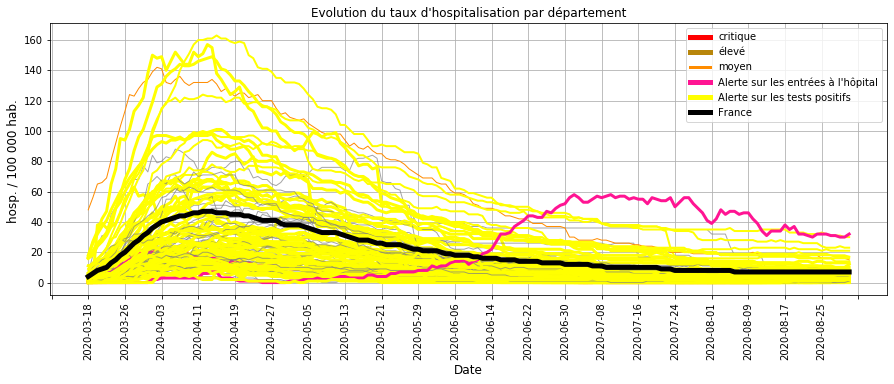

In [40]:
courbe_TxHosp('France')

##### Commentaires :
- La majorité des départements ont des valeurs faibles par rapport au pic de l'épidémie de début avril,
- La plupart des départements (JAUNE) ont un nombre élevé de tests positifs mais un taux d'hospitalisation bas,
- Malgré des entrées encore élevées, la Guyane (ROSE) a un taux d'hospitalisation qui baisse.

### A.2 - Taux d'hospitalisation les plus élevés

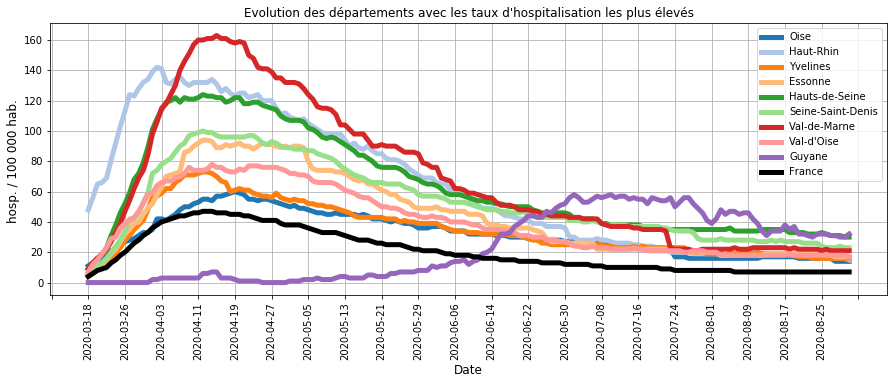

In [41]:
courbe_TxHospHaut('France')

##### Commentaires : 
Les départements avec des taux d'hospitalisation élevés sont à la baisse avec des valeurs très inférieures au pic de l'épidémie d'Avril.

### B.1 - Taux d'entrée à l'hôpital
##### Description :
Le taux d'entrée à l'hôpital traduit la dynamique de l'épidémie dans un département.

En effet, le nombre d'hospitalisation est proportionnel (décalé dans le temps) au nombre de contamination et les entrées à l'hôpital au nombre de nouveaux cas.
Plus le rapport entre les entrées à l'hôpital et les hospitalisations est élevé, plus le rapport équivalent entre les nouveaux cas et les contaminations est élevé et donc  plus importante est la transmission du virus.

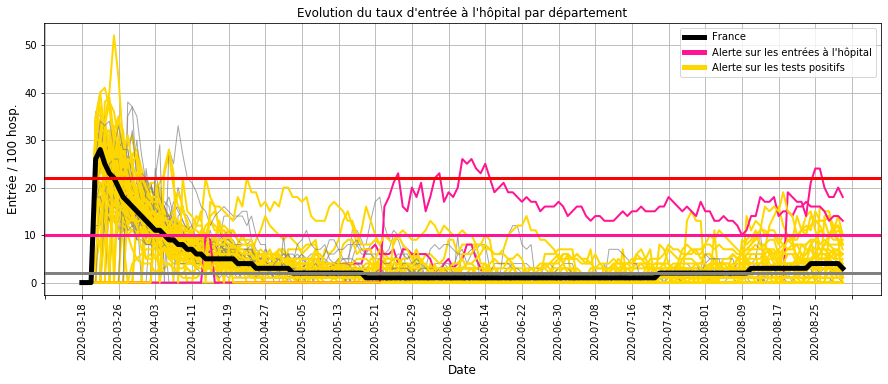

In [42]:
courbe_TxEntree('France')

##### Commentaires :
La comparaison du taux d'entrée à l'hôpital et l'évolution du taux d'hospitalisation (cf. A.1) montre que : 
- le taux d'entrée atteint 20 % au pic de l'épidémie (**limite Rouge**),
- il s'approche des 10 % lorsque l'épidémie repart ou commence à ralentir (**limite Rose**),
- il est inférieur à 5 % lorsque la vitesse de circulation du virus est faible.

Depuis le déconfinement (mai) et jusqu'à fin juillet, quelques départements ont ponctuellement un taux qui augmente.
Depuis mi-aout, la plupart des départements ont un taux d'entrée qui augmente, tout en restant bas.

Seuls La **Guyane** et l'**Hérault** (ROSE) ont un taux d'entrée élevé.

### B-2 - Alerte les entrées à l'hôpital
##### Description :
Le graphique de **gauche** permet de suivre **l'évolution hospitalière** :
- taux d'hospitalisation (BLEU) pour le département / (NOIR EPAIS) pour la France,
- taux d'entrée à l'hôpital (GRIS EPAIS) pour le département / (NOIR FIN) pour la France,
- le trait ROSE est la limite du taux d'entrée où l'épidémie s'accélère.

Le graphique de **droite** permet de suivre les **résultats des tests de dépistage** :
- nombre d'entrée à l'hôpital du département (BLEU) et de la France (NOIR EPAIS) pour 100 000 habitants,
- nombre tests positifs du département (GRIS) et de la la France (NOIR FIN) pour 100 000 habitants.

Les **POINTS ROUGES** représentent les jours où le modèle génère une alerte à partir des tests positifs.

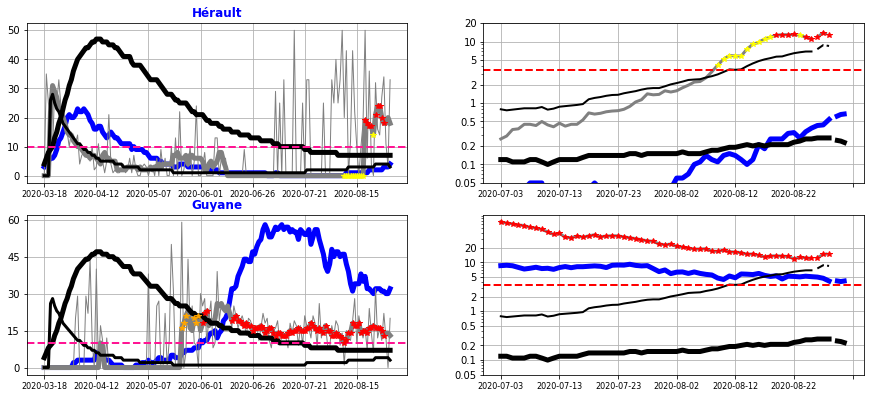

In [43]:
#Dj['jour'].max()
courbe_departement(Dj[(Dj['jour'] == dateTVlast) & (Dj['AlerteTest'] == 'AlV') | 
                     (Dj['jour'] > dateTVlast) & (Dj['alerte'] == True )]['DEP'].drop_duplicates().values)

##### Commentaires :
La **Guyane** a eu un taux d'entrée à l'hôpital (GRIS FONCE à gauche) élevé depuis fin mai qui s'est traduit par une forte augmentation du taux d'hospitalisation (BLEU à gauche) au delà du pic épidémique en France (mi-avril).

La baisse du taux d'entrée à l'hôpital depuis juillet (25 à 15 %) et plus fortement depuis début août (10 %) indique que l'épidémie ralentit.

L'**Hérault** a un taux d'entrée à l'hôpital qui augmente depuis 2 semaines (20 août)(Gris à gauche) qui se traduit par une multiplication par quatre des hospitalisations (Bleu à gauche).

### B-3 - Alerte sur les entrées à l'hôpital sans tests de dépistage massif
##### Description :
L'objectif est de vérifier que les départements dont les taux d'entrée à l'hôpital sont élevés pratiquent des tests massifs de dépistage.

In [44]:
if Dj[(Dj['jour'] == dateTVlast) & (Dj['AlerteTest'] == 'ND')]['DEP'].drop_duplicates().values.size > 0:
    courbe_departement(Dj[(Dj['jour'] ==dateTVlast) & (Dj['AlerteTest'] == 'ND')]['DEP'].drop_duplicates().values)
else:print("Aucun département a un taux d'entrée à l'hôpital élevé et un nombre de tests positifs faible.")

Aucun département a un taux d'entrée à l'hôpital élevé et un nombre de tests positifs faible.


##### Commentaires :

Contrairement au début du déconfinement où des entrées élevées à l'hôpital ne se traduisaient pas systématiquement par une hausse des tests positifs, les tests de dépistage sont généralisés à l'ensemble des départements.

### C.1 - Taux de tests virologiques positifs

#### Description :

Il s'agit de surveiller l'évolution du taux de tests virologiques positifs (pour 100 000 hab.) afin d'anticiper une éventuelle accélération de l'épidémie.

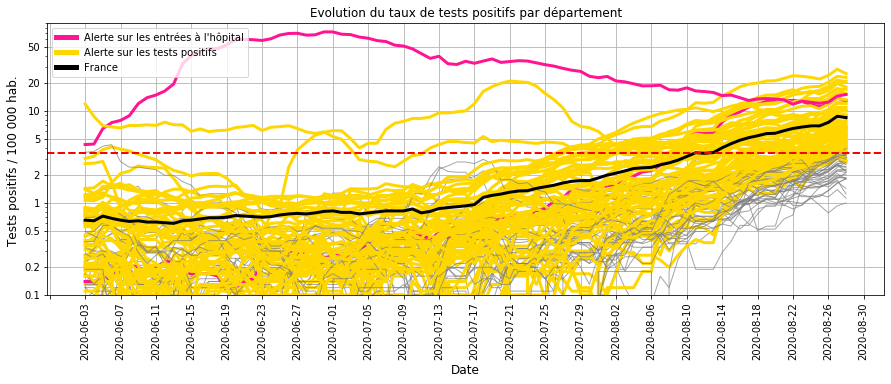

In [45]:
courbe_TxTestPositif()

#### Commentaires :
Depuis 2 semaines, la moyenne nationale (NOIR) a un nombre de tests positifs supérieur au seuil d'alerte calculé au  début du déconfinement (début mai). 

Contrairement au début du déconfinement, cette hausse ne se traduit pas systématiquement par une hausse aussi élevée des entrées à l'hôpital.

De plus, l'exemple de la Mayenne (courbe jaune élevée mi juillet) montre qu'une hausse très importante des tests positifs n'a pas générée une hausse importante des entrées à l'hôpital.

C'est pourquoi actuellement, il est difficile d'utiliser cette indicateur comme une alerte qui anticiperait l'accélération des cas graves.

In [56]:
'''
### C-2 - Alerte sur les tests positifs
##### Description :
L'objectif est de recenser les départements dont les tests positifs augmentent alors que le taux d'entrée à l'hôpital est encore faible.
Cela permet d'anticiper une accélération de l'épidémie.

le graphique de **gauche** permet de suivre **l'évolution hospitalière** :
- taux d'hospitalisation (BLEU) pour le département / (NOIR EPAIS) pour la France,
- taux d'entrée à l'hôpital (GRIS EPAIS) pour le département / (NOIR FIN) pour la France,
- le trait ROSE est la limite du taux d'entrée où l'épidémie s'accélère.

Le graphique de **droite** permet de suivre les **résultats des tests de dépistage** :
- nombre d'entrée à l'hôpital du département (BLEU) et de la France (NOIR EPAIS) pour 100 000 habitants,
- nombre tests positifs du département (GRIS) et de la la France (NOIR FIN) pour 100 000 habitants.

Les **POINTS JAUNE** représentent les jours où le modèle génère une alerte sur les tests positifs.
'''
print()

In [55]:
#courbe_departement(Dj[(Dj['jour'] == dateTVlast) & (Dj['AlerteTest'] == 'AlF')]['DEP'].drop_duplicates().values)
#courbe_departement(Dj[(Dj['jour'] == dateTVlast) & (Dj['AlerteTest'] == 'AlF')].sort_values(by = 'Emoy',ascending = False)['DEP'].values)

In [57]:
'''
##### Commentaires :

La **mayenne** a eu une hausse des tests positifs (GRIS à droite) fin juin puis une diminution depuis 2 semaines qui se confirme par une baisse des entrées à l'hôpital (BLEU à droite). Pendant cette période, le taux d'entrée à l'hôpital (GRIS à gauche) est resté bas, ce qui s'est traduit par une croissance lente des hospitalisations. La circulation du virus y a donc été maîtrisée.

**Paris** et les **Alpes-Maritimes** ont une hausse des tests positifs accompagnée d'une hausse des entrées à l'hôpital mais Le taux d'hospitalisation reste actuellement bas. Cette amorce d'accélération sur les cas graves est à surveiller par un dépistage massif.

Pour les autres départements, la hausse continue du nombre de tests positifs ne se traduit pas par une hausse équivalente des entrées à l'hôpital. Il n'y a donc pas d'accélération des cas graves.
'''
print()

## V. Bilan sur la circulation du virus au 31 août 2020

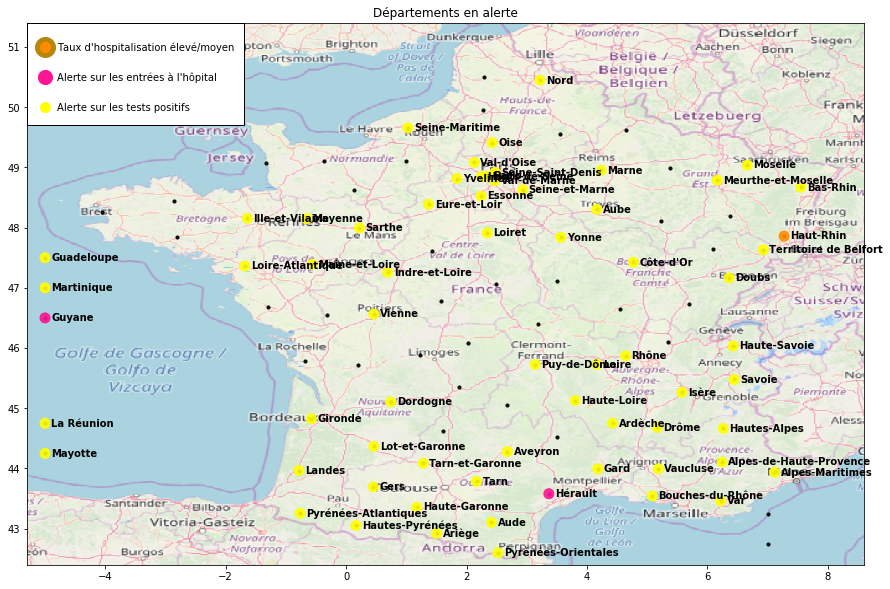

In [47]:
carte_alerte()

Pour de nombreux départements, la hausse généralisée depuis mi-juillet des tests virologiques positifs  ne se traduit pas par une augmentation aussi élevée des hospitalisations (c'est-à-dire des cas graves).

La **Guyane** a eu une hausse des hospitalisations depuis fin mai. Des mesures plus strictes depuis juillet les font progressivement baisser. La baisse du nombre de tests positifs confirme cette tendance. L'épidémie ralentit.

L'**Hérault** a depuis 2 semaines une hausse très rapide des hospitalisations dont la confirmation sur les deux prochaines semaines nécessiterait des mesures plus stricts.

In [48]:
 print("Merci pour votre attention.")

Merci pour votre attention.
